In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from scipy.linalg import cholesky, solve_triangular
from scipy.optimize import minimize
from joblib import Parallel, delayed
output_path_pic = Path(r"C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\Pictures Assignment 2")
output_path_tables = Path(r"C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables")
output_path_pic.mkdir(parents=True, exist_ok=True)
output_path_tables.mkdir(parents=True, exist_ok=True)


## Code for linear shrinkage

## Q1.1

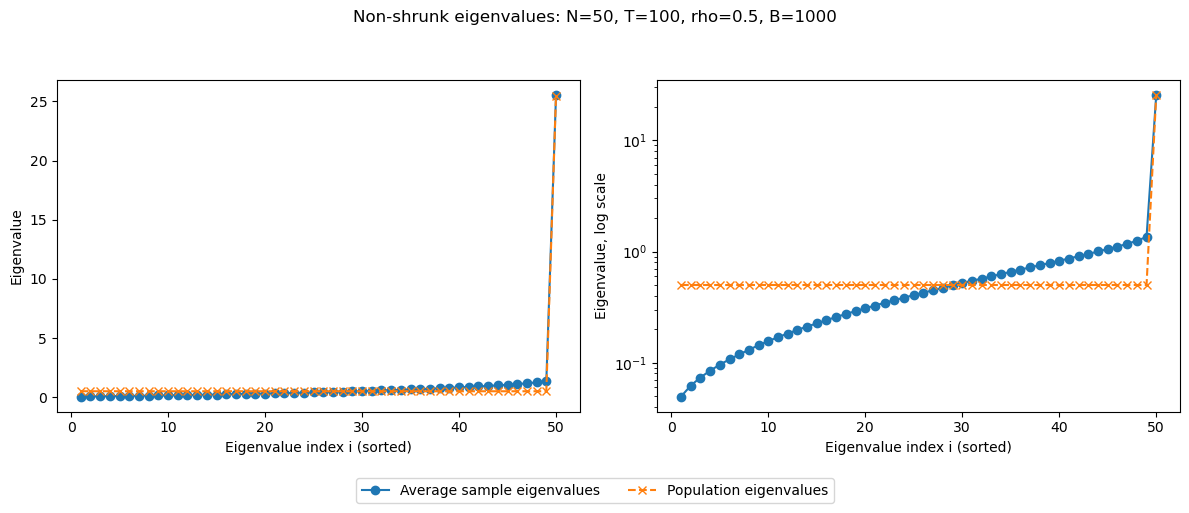

In [20]:
N = 50
T = 100
B = 1000
rho = 0.5
seed = 1827

rng = np.random.default_rng(seed)


#Build equicorrelated Sigma
#Sigma = (1-rho) I + rho 11'
I = np.eye(N)
one = np.ones((N, 1))
Sigma = (1 - rho) * I + rho * (one @ one.T)  # N x N

# Population eigenvalues for equicorrelation:
# (1-rho) with multiplicity N-1, and 1+(N-1)rho once
pop_eigs = np.array([1 - rho] * (N - 1) + [1 + (N - 1) * rho])
pop_eigs.sort()  # ascending


# Monte Carlo loop
eigs_store = np.empty((B, N))

for b in range(B):
    # Simulate Y: T draws of N-dim normal with covariance Sigma
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    # Sample covariance S = (1/T) (Y-mean)'(Y-mean)
    mean = Y.mean(axis=0)
    Y = Y - mean
    S = (Y.T @ Y) / T

    # Eigenvalues 
    lam = np.linalg.eigvalsh(S)  # already real, sorted ascending, used A.I. to determine which function to use on python
    eigs_store[b, :] = lam


avg_eigs = eigs_store.mean(axis=0)
i = np.arange(1, N + 1)

#plot (I added the plot also in a non-log scale,a nd used A.I. to make the graph more readable)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fig.suptitle(f"Non-shrunk eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

# left panel
axes[0].plot(i, avg_eigs, marker="o", linestyle="-", label="Average sample eigenvalues")
axes[0].plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues")
axes[0].set_xlabel("Eigenvalue index i (sorted)")
axes[0].set_ylabel("Eigenvalue")

# right panel
axes[1].plot(i, avg_eigs, marker="o", linestyle="-", label="Average sample eigenvalues")
axes[1].plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues")
axes[1].set_xlabel("Eigenvalue index i (sorted)")
axes[1].set_ylabel("Eigenvalue, log scale")
axes[1].set_yscale("log")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.06, 1, 0.93])

plt.show()
out_path = output_path_pic / "A2_Fig1.png" 
fig.savefig(out_path, dpi=300, bbox_inches="tight")


## Q1.2

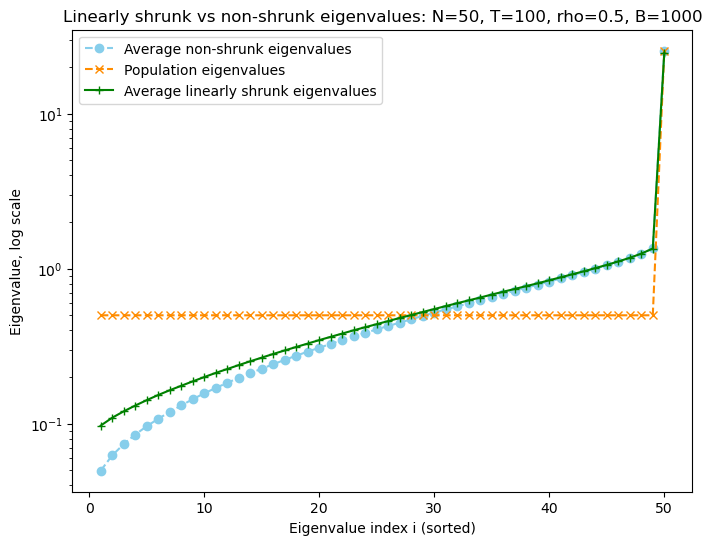

In [21]:
def cov1Para(Y,k = None): #the code to obtain this linear shrinkage function is 
                          #retrieved from the following github repository: https://github.com/pald22/covShrinkage/blob/main/cov1Para.py

    #default setting
    if k is None or math.isnan(k):
        mean = Y.mean(axis=0)
        Y = Y.sub(mean, axis=1)                               #demean
        k = 1

    #vars
    T,N= Y.shape
    n = T-k                                  
   
    
    #Cov df: sample covariance matrix
    sample = pd.DataFrame(np.matmul(Y.T.to_numpy(),Y.to_numpy()))/n     
    
    # compute shrinkage target
    diag = np.diag(sample.to_numpy())
    meanvar= sum(diag)/len(diag)
    target=meanvar*np.eye(N)
    
    # estimate the parameter that we call pi in Ledoit and Wolf (2003, JEF)
    Y2 = pd.DataFrame(np.multiply(Y.to_numpy(),Y.to_numpy()))
    sample2= pd.DataFrame(np.matmul(Y2.T.to_numpy(),Y2.to_numpy()))/n     # sample covariance matrix of squared returns
    piMat=pd.DataFrame(sample2.to_numpy()-np.multiply(sample.to_numpy(),sample.to_numpy()))
    
    pihat = sum(piMat.sum())
    

    # estimate the parameter that we call gamma in Ledoit and Wolf (2003, JEF)
    gammahat = np.linalg.norm(sample.to_numpy()-target,ord = 'fro')**2
    

    # diagonal part of the parameter that we call rho 
    rho_diag=0;
    
    # off-diagonal part of the parameter that we call rho 
    rho_off=0;
    
    # compute shrinkage intensity
    rhohat=rho_diag+rho_off
    kappahat=(pihat-rhohat)/gammahat
    shrinkage=max(0,min(1,kappahat/n))
    
    # compute shrinkage estimator
    sigmahat=shrinkage*target+(1-shrinkage)*sample
    
    return sigmahat


eigs_linear_store = np.empty((B, N))

for b in range(B):
    # Simulate Y: T draws of N-dim normal with covariance Sigma
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    # Substitute the sample covariance with the linearly shrunk covariance
    sigmahat = cov1Para(pd.DataFrame(Y), k=None)
    # Eigenvalues 
    lam = np.linalg.eigvalsh(sigmahat)  # already real, sorted ascending, used A.I. to determine which function to use on python
    eigs_linear_store[b, :] = lam   

avg_eigs_linear = eigs_linear_store.mean(axis=0)
i = np.arange(1, N + 1)


fig = plt.figure(figsize=(8, 6))
plt.plot(i, avg_eigs, marker="o", linestyle="--", label="Average non-shrunk eigenvalues", color= "skyblue")
plt.plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues", color = "darkorange")
plt.plot(i, avg_eigs_linear, marker="+", linestyle="-", label="Average linearly shrunk eigenvalues", color = "green")

plt.xlabel("Eigenvalue index i (sorted)")
plt.ylabel("Eigenvalue, log scale")
plt.yscale("log")
plt.legend()
plt.title(f"Linearly shrunk vs non-shrunk eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

plt.show()
out_path = output_path_pic / "A2_Fig2.png" 
fig.savefig(out_path, dpi=300, bbox_inches="tight")



## Q1.3

Estimated covariance matrix from oracle eigenvalues:
 [[0.9959937  0.49958036 0.50019087 ... 0.50014243 0.4987532  0.49907121]
 [0.49958036 0.99271088 0.49851438 ... 0.49869842 0.49708097 0.49758396]
 [0.50019087 0.49851438 0.99378647 ... 0.49914448 0.49734704 0.49812777]
 ...
 [0.50014243 0.49869842 0.49914448 ... 0.99386372 0.49754277 0.49800745]
 [0.4987532  0.49708097 0.49734704 ... 0.49754277 0.99094473 0.49664814]
 [0.49907121 0.49758396 0.49812777 ... 0.49800745 0.49664814 0.99187191]]


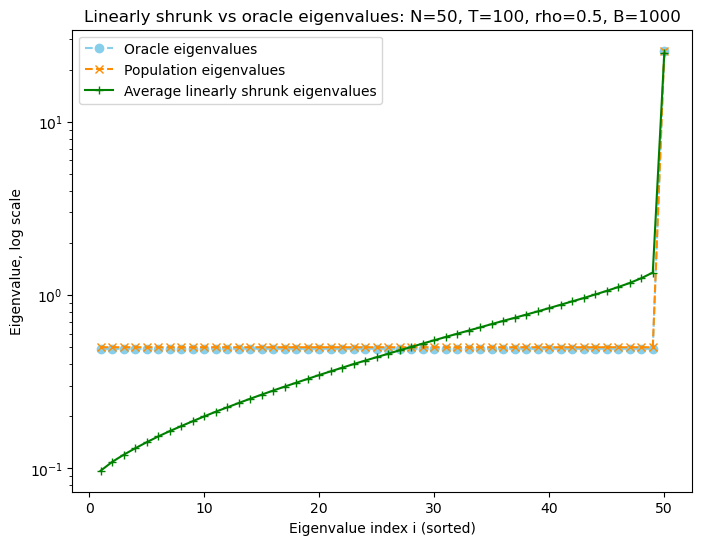

[ 0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861  0.48974861
  0.48974861 25.70261853]
[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.5 25.5]


In [27]:
oracle_eigs = np.zeros((B, N))
sigma_oracle = np.zeros((B, N, N))

for b in range(B):
    Y = rng.multivariate_normal(mean=np.zeros(N), cov=Sigma, size=T)

    Y = Y - Y.mean(axis=0)
    S = (Y.T @ Y) / T

    # --- CHANGE: compute eigenvalues + eigenvectors ---
    lam, U = np.linalg.eigh(S)  # lam ascending, U columns are eigenvectors

    # oracle eigenvalues: replace first N-1 by their mean, keep largest
    oracle_eigs[b, :-1] = np.mean(lam[:-1])
    oracle_eigs[b, -1]  = lam[-1]

    sigma_oracle[b, :, :] = U @ np.diag(oracle_eigs[b, :]) @ U.T

avg_eigs_oracle = oracle_eigs.mean(axis=0)
est_sigma_oracle = sigma_oracle.mean(axis=0)
i = np.arange(1, N + 1)

print("Estimated covariance matrix from oracle eigenvalues:\n", est_sigma_oracle)

fig = plt.figure(figsize=(8, 6))
plt.plot(i, avg_eigs_oracle, marker="o", linestyle="--", label="Oracle eigenvalues", color="skyblue")
plt.plot(i, pop_eigs, marker="x", linestyle="--", label="Population eigenvalues", color="darkorange")
plt.plot(i, avg_eigs_linear, marker="+", linestyle="-", label="Average linearly shrunk eigenvalues", color="green")
plt.xlabel("Eigenvalue index i (sorted)")
plt.ylabel("Eigenvalue, log scale")
plt.yscale("log")
plt.legend()
plt.title(f"Linearly shrunk vs oracle eigenvalues: N={N}, T={T}, rho={rho}, B={B}")

out_path = output_path_pic / "A2_Fig3.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(avg_eigs_oracle)
print(pop_eigs)


## Q1.4

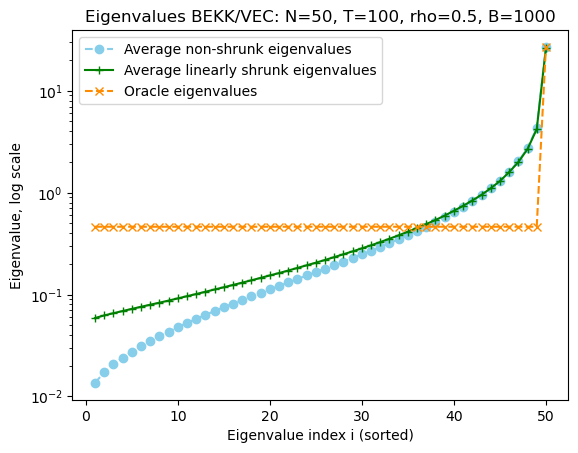

Saved to: C:\Users\fipli\OneDrive - UvA\TI Master content\2.3 Advanced Time Series Econometrics\Assignment 2\latex_tables


In [28]:
N = 50
T = 100
B = 1000
rho = 0.5
seed = 1827
alpha = 0.05
beta = 0.93

rng = np.random.default_rng(seed)

I = np.eye(N)
one = np.ones((N, 1))
equicorr_sigma = (1 - rho) * I + rho * (one @ one.T)

def simulate_bekk_vec(T, alpha, beta, rng):
    """
    Simulate y_t from:
      Sigma_t = (1-a-b) Sigma + a y_{t-1} y'_{t-1} + b Sigma_{t-1}
      y_t | F_{t-1} ~ N(0, Sigma_t)
    """
    N = equicorr_sigma.shape[0]
    y = np.zeros((T, N))
    Sig_t = equicorr_sigma.copy()  # Sigma_0
    Sig_prev = Sig_t
    y_prev = rng.multivariate_normal(np.zeros(N), equicorr_sigma)

    for t in range(T):
        Sig_t = (1 - alpha - beta) * equicorr_sigma + alpha * np.outer(y_prev, y_prev) + beta * Sig_prev
        y[t] = rng.multivariate_normal(np.zeros(N), Sig_t)
        y_prev = y[t]
        Sig_prev = Sig_t

    return y

y_simulated = np.zeros((B, T, N))
S_simulated_no_shrinkage = np.zeros((B, N, N))
lam_simulated_no_shrinkage = np.zeros((B, N))
S_simulated_shrinkage = np.zeros((B, N, N))
lam_simulated_shrinkage = np.zeros((B, N))
S_simulated_oracle = np.zeros((B, N, N))
lam_simulated_oracle = np.zeros((B, N))

## Monte Carlo loop with and without shrinkage
for b in range(B):
    y_simulated[b] = simulate_bekk_vec(T, alpha, beta, rng)
    mean = y_simulated[b].mean(axis=0)

    # Sample covariance S = (1/T) (y-mean)'(y-mean)
    y_simulated_demeaned = y_simulated[b] - mean
    S = (y_simulated_demeaned.T @ y_simulated_demeaned) / T

    # --- CHANGE: compute eigenvalues + eigenvectors for S ---
    lam, U = np.linalg.eigh(S)  # lam ascending, U columns are eigenvectors

    S_simulated_no_shrinkage[b] = S
    lam_simulated_no_shrinkage[b] = lam

    # Shrinkage (unchanged)
    Sigma_hat = cov1Para(pd.DataFrame(y_simulated[b]), k=None)
    lam_shrunk = np.linalg.eigvalsh(Sigma_hat)
    S_simulated_shrinkage[b] = Sigma_hat
    lam_simulated_shrinkage[b] = lam_shrunk

    # --- CHANGE: Oracle eigenvalues + oracle covariance via eigenvectors ---
    lam_simulated_oracle[b, :-1] = np.mean(lam[:-1])
    lam_simulated_oracle[b, -1]  = lam[-1]
    S_simulated_oracle[b, :, :]  = U @ np.diag(lam_simulated_oracle[b, :]) @ U.T

lam_simulated_no_shrinkage_avg = lam_simulated_no_shrinkage.mean(axis=0)
lam_simulated_shrinkage_avg = lam_simulated_shrinkage.mean(axis=0)
lam_simulated_oracle_avg = lam_simulated_oracle.mean(axis=0)

fig = plt.figure()
plt.plot(np.arange(1, N + 1), lam_simulated_no_shrinkage_avg, marker="o", linestyle="--",
         label="Average non-shrunk eigenvalues", color="skyblue")
plt.plot(np.arange(1, N + 1), lam_simulated_shrinkage_avg, marker="+", linestyle="-",
         label="Average linearly shrunk eigenvalues", color="green")
plt.plot(np.arange(1, N + 1), lam_simulated_oracle_avg, marker="x", linestyle="--",
         label="Oracle eigenvalues", color="darkorange")
plt.xlabel("Eigenvalue index i (sorted)")
plt.ylabel("Eigenvalue, log scale")
plt.yscale("log")
plt.legend()
plt.title(f"Eigenvalues BEKK/VEC: N={N}, T={T}, rho={rho}, B={B}")
plt.show()
out_path = output_path_pic / "A2_Fig4.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")

no_shrunk_estimated_sigma = np.mean(S_simulated_no_shrinkage, axis=0)
linear_shrunk_estimated_sigma = np.mean(S_simulated_shrinkage, axis=0)
oracle_estimated_sigma = np.mean(S_simulated_oracle, axis=0)

def cut_with_dots(A, k=6):
    assert k == 6
    n = A.shape[0]
    idx = [0, 1, 2, 3, n-2, n-1]

    B = np.empty((k, k), dtype=object)
    for i, ii in enumerate(idx):
        for j, jj in enumerate(idx):
            B[i, j] = A[ii, jj]

    for j in range(k):
        B[4, j] = r"\vdots"
    for i in range(k):
        B[i, 4] = r"\cdots"
    B[4, 4] = r"\ddots"
    return B

def to_latex_table(B, floatfmt="{:.4f}"):
    def fmt(x):
        if isinstance(x, (float, int, np.floating, np.integer)):
            return floatfmt.format(float(x))
        return x

    df = pd.DataFrame([[fmt(x) for x in row] for row in B])
    return df.to_latex(index=False, header=False, escape=False, column_format="r"*df.shape[1])

# build cut tables
B_no     = cut_with_dots(no_shrunk_estimated_sigma)
B_linear = cut_with_dots(linear_shrunk_estimated_sigma)
B_oracle = cut_with_dots(oracle_estimated_sigma)

# save each as its own .tex
(output_path_tables / "sigma_no_cut.tex").write_text(to_latex_table(B_no), encoding="utf-8")
(output_path_tables / "sigma_lin_cut.tex").write_text(to_latex_table(B_linear), encoding="utf-8")
(output_path_tables / "sigma_or_cut.tex").write_text(to_latex_table(B_oracle), encoding="utf-8")

print("Saved to:", output_path_tables.resolve())


In [29]:
# ============================================================
# 1) Transform: (a,b) -> (alpha,beta) with alpha,beta >= 0 and alpha+beta < 1
#    Softmax-like mapping:
#      alpha = exp(a)/(1+exp(a)+exp(b))
#      beta  = exp(b)/(1+exp(a)+exp(b))
# ============================================================
def alpha_beta_from_ab(a, b):
    ea, eb = np.exp(a), np.exp(b)
    den = 1.0 + ea + eb
    alpha = ea / den
    beta  = eb / den
    return alpha, beta


# ============================================================
# 2) Build init_H_generic: (B,3,N,N)
# ============================================================
def build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle):
    if init_H_no_shrink.ndim == 2:
        base = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=0)  # (3,N,N)
        init_H_generic = np.broadcast_to(base, (B, 3, N, N)).copy()
    elif init_H_no_shrink.ndim == 3:
        init_H_generic = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=1)  # (B,3,N,N)
    else:
        raise ValueError("init_H_* must be either (N,N) or (B,N,N).")
    return init_H_generic


# ============================================================
# 3) Negative log-likelihood for ONE simulation b and ONE strategy s
#    Scalar BEKK/VEC recursion:
#      H_t = (1-a-b) * Hbar + a * y_{t-1}y_{t-1}' + b * H_{t-1}
#    Here we use y_t y_t' contemporaneously like in your loop.
# ============================================================
def neg_loglik_one_b_one_s(params_ab, y_b, Hbar_s):
    """
    params_ab: array-like length 2 => (a,b) unconstrained
    y_b: (T,N)
    Hbar_s: (N,N) fixed unconditional covariance target for strategy s
    """
    a_raw, b_raw = params_ab
    alpha, beta = alpha_beta_from_ab(a_raw, b_raw)

    T, N = y_b.shape

    # Precompute yy_t = y_t y_t'
    yy = np.einsum("tn,tm->tnm", y_b, y_b)  # (T,N,N)

    H = Hbar_s.copy()
    nll = 0.0

    for t in range(T):
        y = y_b[t]  # (N,)

        # Cholesky factorization: H = L L'
        try:
            L = cholesky(H, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf

        logdet = 2.0 * np.sum(np.log(np.diag(L)))
        z = solve_triangular(L, y, lower=True, check_finite=False)
        quad = float(np.dot(z, z))

        nll += 0.5 * (logdet + quad)

        # Update
        if t < T - 1:
            H = (1.0 - alpha - beta) * Hbar_s + alpha * yy[t] + beta * H

    return nll


# ============================================================
# 4) Estimate (alpha,beta) for one simulation b, separately for each strategy s
# ============================================================
def estimate_one_b_separate(b, y_simulated, init_H_generic, x0_ab, method, options):
    """
    Returns for simulation b:
      ab_hat:    (3,2)  raw params (a,b) per strategy
      alpha_hat: (3,)   alpha per strategy
      beta_hat:  (3,)   beta  per strategy
      nll_hat:   (3,)   minimized nll per strategy
      success:   (3,)   success flags
      message:   list length 3
    """
    y_b = y_simulated[b]          # (T,N)
    Hbar_b = init_H_generic[b]    # (3,N,N)

    ab_hat = np.zeros((3, 2))
    alpha_hat = np.zeros(3)
    beta_hat  = np.zeros(3)
    nll_hat   = np.zeros(3)
    success   = np.zeros(3, dtype=bool)
    messages  = [""] * 3

    for s in range(3):
        obj = lambda p: neg_loglik_one_b_one_s(p, y_b, Hbar_b[s])
        res = minimize(obj, x0=np.asarray(x0_ab, dtype=float), method=method, options=options)

        ab_hat[s] = res.x
        a_s, b_s = alpha_beta_from_ab(res.x[0], res.x[1])
        alpha_hat[s] = a_s
        beta_hat[s]  = b_s
        nll_hat[s]   = res.fun
        success[s]   = res.success
        messages[s]  = str(res.message)

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages


# ============================================================
# 5) Parallel Monte Carlo estimation: B simulations (each runs 3 separate optimizations)
# ============================================================
def estimate_ab_separate_per_strategy_parallel(
    y_simulated,
    init_H_no_shrink,
    init_H_linear,
    init_H_oracle,
    x0_ab=(0.0, 0.0),
    method="L-BFGS-B",
    options=None,
    n_jobs=-1
):
    """
    y_simulated: (B,T,N)
    Returns:
      ab_hat:    (B,3,2)
      alpha_hat: (B,3)
      beta_hat:  (B,3)
      nll_hat:   (B,3)
      success:   (B,3)
      messages:  list length B, each is list length 3
      summary:   dict with means/sds per strategy
    """
    B, T, N = y_simulated.shape
    init_H_generic = build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle)

    if options is None:
        options = {"maxiter": 20}

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(estimate_one_b_separate)(b, y_simulated, init_H_generic, x0_ab, method, options)
        for b in range(B)
    )

    ab_hat    = np.stack([r[0] for r in results], axis=0)  # (B,3,2)
    alpha_hat = np.stack([r[1] for r in results], axis=0)  # (B,3)
    beta_hat  = np.stack([r[2] for r in results], axis=0)  # (B,3)
    nll_hat   = np.stack([r[3] for r in results], axis=0)  # (B,3)
    success   = np.stack([r[4] for r in results], axis=0)  # (B,3)
    messages  = [r[5] for r in results]

    # summary per strategy s
    summary = {
        "success_rate": success.mean(axis=0),  # (3,)
        "alpha_mean": alpha_hat.mean(axis=0),
        "alpha_sd": alpha_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "beta_mean": beta_hat.mean(axis=0),
        "beta_sd": beta_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "nll_mean": nll_hat.mean(axis=0),
        "nll_sd": nll_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
    }

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary


# ============================================================
# 6) Example call
# ============================================================
ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary = estimate_ab_separate_per_strategy_parallel(
     y_simulated=y_simulated,
     init_H_no_shrink=no_shrunk_estimated_sigma,
     init_H_linear=linear_shrunk_estimated_sigma,
     init_H_oracle=oracle_estimated_sigma,
     x0_ab=(0.0, 0.0),
     method="L-BFGS-B",
     options={"maxiter": 20},
     n_jobs=-1
 )
#
print("Success rate per strategy [no, linear, oracle]:", summary["success_rate"])
print("alpha mean:", summary["alpha_mean"])
print("beta  mean:", summary["beta_mean"])
print("alpha sd:", summary["alpha_sd"])
print("beta  sd:", summary["beta_sd"])

Success rate per strategy [no, linear, oracle]: [0.999 0.997 0.999]
alpha mean: [0.04962417 0.05168627 0.04987238]
beta  mean: [0.93021958 0.92882078 0.93002155]
alpha sd: [0.00236976 0.00244987 0.00238199]
beta  sd: [0.00387977 0.00390434 0.00388541]


In [ ]:
print("alpha mean:", summary["alpha_mean"])
print("beta  mean:", summary["beta_mean"])
print("alpha se:", summary["alpha_sd"]/np.sqrt(B))
print("beta  se:", summary["beta_sd"]/np.sqrt(B))

alpha mean: [0.04962417 0.05168627 0.04733136]
beta  mean: [0.93021958 0.92882078 0.93166512]
alpha se: [7.49383377e-05 7.74715701e-05 7.21902859e-05]
beta  se: [0.00012269 0.00012347 0.00012203]


In [ ]:
# ============================================================
# 1) Transform: (a,b) -> (alpha,beta) with alpha,beta >= 0 and alpha+beta < 1
# ============================================================
def alpha_beta_from_ab(a, b):
    ea, eb = np.exp(a), np.exp(b)
    den = 1.0 + ea + eb
    alpha = ea / den
    beta  = eb / den
    return alpha, beta



# ============================================================
# 2) Build init_H_generic: (B,3,N,N)
# ============================================================
def build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle):
    if init_H_no_shrink.ndim == 2:
        base = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=0)  # (3,N,N)
        init_H_generic = np.broadcast_to(base, (B, 3, N, N)).copy()
    elif init_H_no_shrink.ndim == 3:
        init_H_generic = np.stack([init_H_no_shrink, init_H_linear, init_H_oracle], axis=1)  # (B,3,N,N)
    else:
        raise ValueError("init_H_* must be either (N,N) or (B,N,N).")
    return init_H_generic


# ============================================================
# 3) Negative log-likelihood for ONE simulation b and ONE strategy s
# ============================================================
def neg_loglik_one_b_one_s(params_ab, y_b, Hbar_s):
    """
    params_ab: array-like length 2 => (a,b) unconstrained
    y_b: (T,N)
    Hbar_s: (N,N) fixed unconditional covariance target for strategy s
    """
    a_raw, b_raw = params_ab
    alpha, beta = alpha_beta_from_ab(a_raw, b_raw)

    T, N = y_b.shape

    # Precompute yy_t = y_t y_t'
    yy = np.einsum("tn,tm->tnm", y_b, y_b)  # (T,N,N)

    H = Hbar_s.copy()
    nll = 0.0

    for t in range(T):
        y = y_b[t]  # (N,)

        # Cholesky factorization: H = L L'
        try:
            L = cholesky(H, lower=True, check_finite=False)
        except np.linalg.LinAlgError:
            return np.inf

        logdet = 2.0 * np.sum(np.log(np.diag(L)))
        z = solve_triangular(L, y, lower=True, check_finite=False)
        quad = float(np.dot(z, z))

        nll += 0.5 * (logdet + quad)

        # Update
        if t < T - 1:
            H = (1.0 - alpha - beta) * Hbar_s + alpha * yy[t] + beta * H

    return nll


# ============================================================
# 4) Estimate (alpha,beta) for one simulation b, separately for each strategy s
# ============================================================
def estimate_one_b_separate(b, y_simulated, init_H_generic, x0_ab, method, options):
    """
    Returns for simulation b:
      ab_hat:    (3,2)  raw params (a,b) per strategy
      alpha_hat: (3,)   alpha per strategy
      beta_hat:  (3,)   beta  per strategy
      nll_hat:   (3,)   minimized nll per strategy
      success:   (3,)   success flags
      message:   list length 3
    """
    y_b = y_simulated[b]          # (T,N)
    Hbar_b = init_H_generic[b]    # (3,N,N)

    ab_hat = np.zeros((3, 2))
    alpha_hat = np.zeros(3)
    beta_hat  = np.zeros(3)
    nll_hat   = np.zeros(3)
    success   = np.zeros(3, dtype=bool)
    messages  = [""] * 3

    for s in range(3):
        obj = lambda p: neg_loglik_one_b_one_s(p, y_b, Hbar_b[s])
        res = minimize(obj, x0=np.asarray(x0_ab, dtype=float), method=method, options=options)

        ab_hat[s] = res.x
        a_s, b_s = alpha_beta_from_ab(res.x[0], res.x[1])
        alpha_hat[s] = a_s
        beta_hat[s]  = b_s
        nll_hat[s]   = res.fun
        success[s]   = res.success
        messages[s]  = str(res.message)

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages


# ============================================================
# 5) Parallel Monte Carlo estimation: B simulations (each runs 3 separate optimizations)
# ============================================================
def estimate_ab_separate_per_strategy_parallel(
    y_simulated,
    init_H_no_shrink,
    init_H_linear,
    init_H_oracle,
    x0_ab=(0.0, 0.0),
    method="L-BFGS-B",
    options=None,
    n_jobs=-1
):
    """
    y_simulated: (B,T,N)
    Returns:
      ab_hat:    (B,3,2)
      alpha_hat: (B,3)
      beta_hat:  (B,3)
      nll_hat:   (B,3)
      success:   (B,3)
      messages:  list length B, each is list length 3
      summary:   dict with means/sds per strategy
    """
    B, T, N = y_simulated.shape
    init_H_generic = build_init_H_generic(B, N, init_H_no_shrink, init_H_linear, init_H_oracle)

    if options is None:
        options = {"maxiter": 20}

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(estimate_one_b_separate)(b, y_simulated, init_H_generic, x0_ab, method, options)
        for b in range(B)
    )

    ab_hat    = np.stack([r[0] for r in results], axis=0)  # (B,3,2)
    alpha_hat = np.stack([r[1] for r in results], axis=0)  # (B,3)
    beta_hat  = np.stack([r[2] for r in results], axis=0)  # (B,3)
    nll_hat   = np.stack([r[3] for r in results], axis=0)  # (B,3)
    success   = np.stack([r[4] for r in results], axis=0)  # (B,3)
    messages  = [r[5] for r in results]

    # summary per strategy s
    summary = {
        "success_rate": success.mean(axis=0),  # (3,)
        "alpha_mean": alpha_hat.mean(axis=0),
        "alpha_sd": alpha_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "beta_mean": beta_hat.mean(axis=0),
        "beta_sd": beta_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
        "nll_mean": nll_hat.mean(axis=0),
        "nll_sd": nll_hat.std(axis=0, ddof=1) if B > 1 else np.zeros(3),
    }

    return ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary


# ============================================================
# 6) Example call
# ============================================================
ab_hat, alpha_hat, beta_hat, nll_hat, success, messages, summary = estimate_ab_separate_per_strategy_parallel(
     y_simulated=y_simulated,
     init_H_no_shrink=no_shrunk_estimated_sigma,
     init_H_linear=linear_shrunk_estimated_sigma,
     init_H_oracle=sigma_oracle_estimated,
     x0_ab=(0.0, 0.0),
     method="L-BFGS-B",
     options={"maxiter": 20},
     n_jobs=-1
 )
#
print("Success rate per strategy [no, linear, oracle]:", summary["success_rate"])
print("alpha mean:", summary["alpha_mean"])
print("beta  mean:", summary["beta_mean"])
print("alpha sd:", summary["alpha_sd"])
print("beta  sd:", summary["beta_sd"])

    for t in range(T):
        H_t = (1 - alpha - beta) * Sigma_bar + alpha * np.outer(y_prev, y_prev) + beta * H_t

        # Cholesky for logdet and quadratic form
        try:
            L = cholesky(H_t)
        except np.linalg.LinAlgError:
            return 1e50  # non-PD penalty

        # log |Sig_t| = 2 sum log diag(L)
        logdet = 2.0 * np.sum(np.log(np.diag(L)))

        # quad = y_t' Sig_t^{-1} y_t via solve with Cholesky
        y_t = Y[t]
        # solve L x = y, then L' z = x => z = Sig^{-1} y
        x = solve(L, y_t)
        quad = x @ x

        nll += 0.5 * (logdet + quad + const)
        y_prev = y_t

    return nll

def fit_ab_qml(Y, Sigma_bar, uv0=(np.log(0.05/0.02), np.log(0.93/0.02))):
    # uv0 just gives a starting point; any finite numbers are ok.
    res = minimize(
        neg_qml_uv,
        x0=np.array(uv0, dtype=float),
        args=(Y, Sigma_bar),
        method="Nelder-Mead",
        options={"maxiter": 5000, "xatol": 1e-6, "fatol": 1e-6}
    )
    u_hat, v_hat = res.x
    a_hat, b_hat = ab_from_uv(u_hat, v_hat)
    return a_hat, b_hat, res

def fitted_sigmas(Y, Sigma_bar, alpha, beta):
    T, N = Y.shape
    Sigmas = np.zeros((T, N, N))
    Sig_t = Sigma_bar.copy()
    y_prev = Y[0]
    for t in range(T):
        Sig_t = (1 - alpha - beta) * Sigma_bar + alpha * np.outer(y_prev, y_prev) + beta * Sig_t
        Sigmas[t] = Sig_t
        y_prev = Y[t]
    return Sigmas

def minvar_portfolio_var(Y, Sigmas):
    T, N = Y.shape
    one = np.ones(N)
    rets = np.zeros(T)
    for t in range(T):
        Sig = Sigmas[t]
        # w = Sig^{-1}1 / (1' Sig^{-1} 1)
        x = np.linalg.solve(Sig, one)
        w = x / (one @ x)
        rets[t] = w @ Y[t]
    return np.var(rets, ddof=1)

# -----------------------------
# Monte Carlo experiment
# -----------------------------
def run_mc(N=50, T=100, B=500, rho=0.5, alpha0=0.05, beta0=0.93, seed=1827):
    rng = np.random.default_rng(seed)
    Sigma_true = equicorr_sigma(N, rho)

    methods = {
        "Sample": no_shrink,
        "LinearShrink": lambda S: shrink_to_identity(S, delta=0.2),   # replace with your delta estimator
        "EigAvg(N-1)": eigen_avg_first_Nm1,
    }

    out = {k: [] for k in methods.keys()}

    for b in range(B):
        Y = simulate_vec_bekk(T, Sigma_true, alpha0, beta0, rng)

        S = sample_cov(Y)

        for name, Sigma_hat_fn in methods.items():
            Sigma_bar_hat = Sigma_hat_fn(S)

            a_hat, b_hat, _ = fit_ab_qml(Y, Sigma_bar_hat)
            Sigmas_hat = fitted_sigmas(Y, Sigma_bar_hat, a_hat, b_hat)

            pv = minvar_portfolio_var(Y, Sigmas_hat)
            out[name].append(pv)

    # averages over MC replications
    return {k: (np.mean(v), np.std(v)) for k, v in out.items()}


results = run_mc(N=50, T=100, B=1000, rho=0.5)





SyntaxError: expected ':' (1731143109.py, line 1)